In [10]:
import json
import os
import sys

import torch

import json
import os
from tqdm import tqdm

import torch
from PIL import Image, ImageFile

from torch import nn
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset, config

ImageFile.LOAD_TRUNCATED_IMAGES = True  # To handle truncated (corrupted) images

custom_download_path = "/data/SSD2/HF_datasets"
config.HF_DATASETS_CACHE = custom_download_path

from transformers import AutoTokenizer, AutoImageProcessor
preprocess = AutoImageProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [11]:
class CDC_test(Dataset):

    def __init__(
        self, annotation_path, image_path, preprocess, ratio=0.1
    ):
        self.annotations = json.load(open(annotation_path))
        self.annotations = self.annotations[: int(len(self.annotations) * ratio)]
        self.image_path = image_path
        self.vis_processors = preprocess

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        img_path = os.path.join(self.image_path, annotation["image"])
        raw_image = Image.open(img_path).convert("RGB")
        image_input = self.vis_processors(raw_image, return_tensors="pt")
        if "pixel_values" in image_input:
            image_input["pixel_values"] = image_input["pixel_values"].squeeze()

        raw_text = (
            self.annotations[idx]["caption"]
            if type(self.annotations[idx]["caption"]) == str
            else self.annotations[idx]["caption"][0]
        )

        return image_input, raw_text

In [13]:
path = "/data/SSD/flickr30k/annotations/test.json"
annotation = json.load(open(path, "r"))

test_dataset = CDC_test(
    annotation_path=path,
    image_path="/data/SSD/flickr30k/images",
    preprocess=preprocess,
    ratio=1
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=1024,
    shuffle=False,
    # num_workers=cfg.train.num_workers,
)

In [23]:
path_txt = "/project/Deep-Clustering/res/20240717_102331_flickr30k-preextracted/all_txt_emb_21.pt"
path_img = "/project/Deep-Clustering/res/20240717_102331_flickr30k-preextracted/all_img_emb_21.pt"
path_comb = "/project/Deep-Clustering/res/20240717_102331_flickr30k-preextracted/all_best_comb_emb_21.pt"

txt_emb = torch.tensor(torch.load(path_txt))
img_emb = torch.tensor(torch.load(path_img))
comb_emb = torch.tensor(torch.load(path_comb))

In [24]:
# Perform k-means
import numpy as np
import torch

from dask_cuda import LocalCUDACluster
from cuml import KMeans
from cuml.cluster import KMeans
from dask.distributed import Client
import dask.array as da
from cuml.datasets import make_blobs
from cuml.manifold import UMAP
from cuml.dask.manifold import UMAP as MNMG_UMAP
from cuml import DBSCAN, HDBSCAN
from cuml.cluster import DBSCAN, HDBSCAN

In [25]:
class Clustering:
    def __init__(self, embedding_manager, device="cuda"):
        self.embedding_manager = embedding_manager
        self.device = torch.device(device if torch.cuda.is_available() else "cpu")
        self.cluster = None
        self.client = None

    def initialize_cluster(self):
        # Initialize Dask CUDA cluster and client
        self.cluster = LocalCUDACluster(threads_per_worker=1)
        self.client = Client(self.cluster)

    def close_cluster(self):
        # Close Dask CUDA cluster and client
        self.client.close()
        self.cluster.close()

    def get_umap(self, label_embedding):
        # Perform UMAP dimensionality reduction on embeddings
        self.initialize_cluster()

        label_embedding = label_embedding.to(self.device)
        label_embedding_np = label_embedding.cpu().numpy()

        local_model = UMAP(random_state=42)
        umap_features = local_model.fit_transform(label_embedding_np)

        self.close_cluster()

        umap_features = torch.tensor(umap_features, device=self.device)
        return umap_features

In [26]:
clustering = Clustering(embedding_manager=None, device="cuda")

In [27]:
umap_txt = clustering.get_umap(txt_emb)
umap_img = clustering.get_umap(img_emb)
umap_comb = clustering.get_umap(comb_emb)

/opt/conda/envs/deepclustering/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38277 instead
  warnings.warn(
/opt/conda/envs/deepclustering/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37189 instead
  warnings.warn(
/opt/conda/envs/deepclustering/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39077 instead
  warnings.warn(


In [31]:
# Plot UMAP
import matplotlib.pyplot as plt
import seaborn as sns

umap_txt_np = umap_txt.cpu().numpy()
umap_img_np = umap_img.cpu().numpy()
umap_comb_np = umap_comb.cpu().numpy()


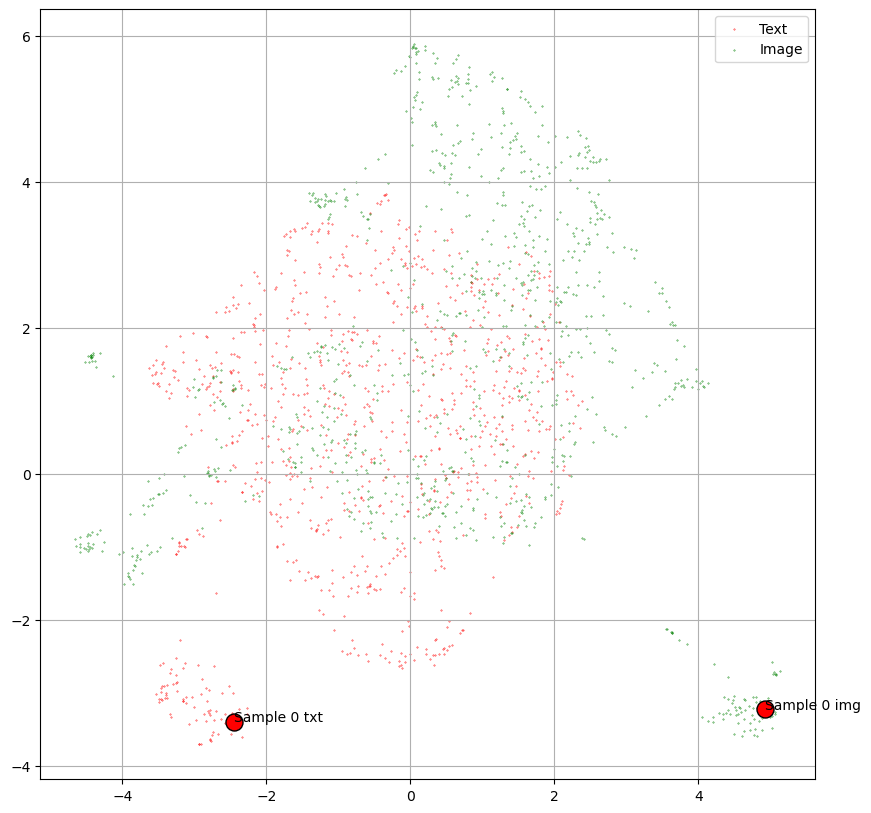

In [37]:

fig = plt.figure(figsize=(10, 10))
plt.scatter(umap_txt_np[:, 0], umap_txt_np[:, 1], s=0.1, c="r", label="Text")
plt.scatter(umap_img_np[:, 0], umap_img_np[:, 1], s=0.1, c="g", label="Image")

x, y = umap_img_np[1, :]
plt.scatter(x, y, c="red", s=150, edgecolors="k")  # Highlight the sample
plt.text(
    x, y, f"Sample {0} img", fontsize=10, color="black"
)  # Annotate the sample

x, y = umap_txt_np[1, :]
plt.scatter(x, y, c="red", s=150, edgecolors="k")  # Highlight the sample
plt.text(
    x, y, f"Sample {0} txt", fontsize=10, color="black"
)  # Annotate the sample



plt.legend()
plt.grid()
plt.show()

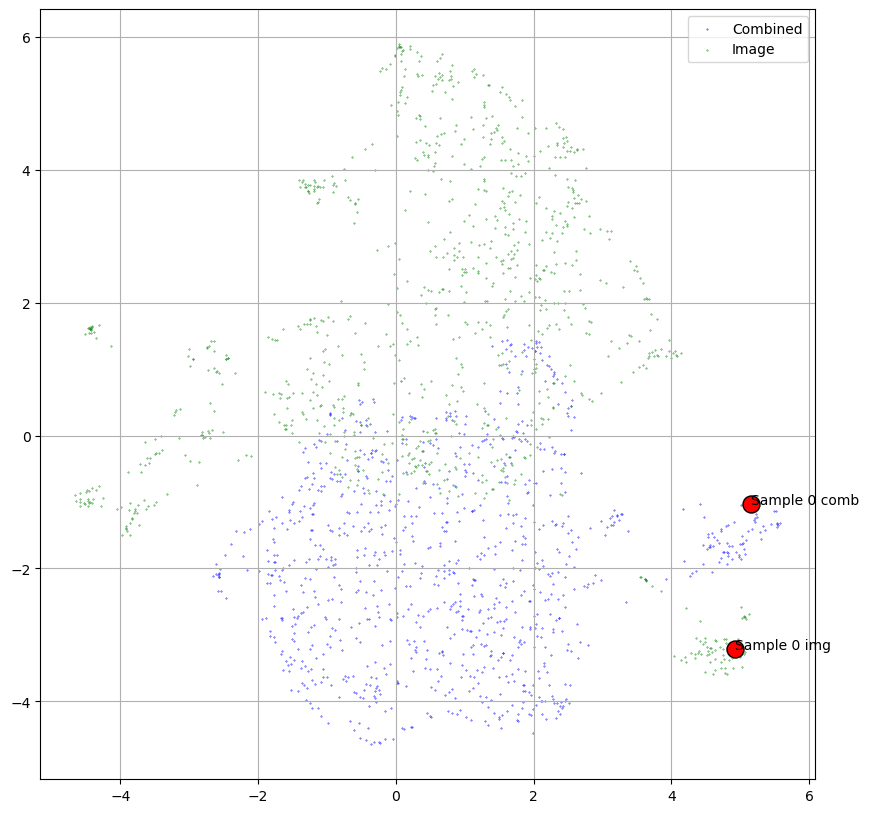

In [38]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(umap_comb_np[:, 0], umap_comb_np[:, 1], s=0.1, c="b", label="Combined")
plt.scatter(umap_img_np[:, 0], umap_img_np[:, 1], s=0.1, c="g", label="Image")

x, y = umap_img_np[1, :]
plt.scatter(x, y, c="red", s=150, edgecolors="k")  # Highlight the sample
plt.text(
    x, y, f"Sample {0} img", fontsize=10, color="black"
)  # Annotate the sample

x, y = umap_comb_np[1, :]
plt.scatter(x, y, c="red", s=150, edgecolors="k")  # Highlight the sample
plt.text(
    x, y, f"Sample {0} comb", fontsize=10, color="black"
)  # Annotate the sample

plt.legend()
plt.grid()
plt.show()

In [ ]:
anno